SDO/AIA Synoptic FITS Data

The AIA Synoptic FITS data are reduced to 1024x1024 2.4 arc-sec pixels by summing with pixel value in DN per original 0.6 arc-sec pixel. The data cadence is 2 minutes. These images are produced approximately 7 days after T_OBS since they are derived from definitive level 1 data.

- https://hpde.io/NASA/NumericalData/SDO/AIA/Synoptic/PT120S.html

In [ ]:
import os
import s3fs
import zarr

from typing import Union

import numpy as np
import dask.array as da
import astropy.units as u
from sunpy.net import Fido, attrs as a
from sunpy.map import Map


def s3_connection(path_to_zarr: os.path) -> s3fs.S3Map:
    """
    Instantiate connection to aws for a given path `path_to_zarr`
    """
    return s3fs.S3Map(
        root=path_to_zarr,
        s3=s3fs.S3FileSystem(anon=True),
        # anonymous access requires no credentials
        check=False,
    )


def load_single_aws_zarr(
    path_to_zarr: os.path,
    cache_max_single_size: int = None,
) -> Union[zarr.Array, zarr.Group]:
    """
    load zarr from s3 using LRU cache
    """
    return zarr.open(
        zarr.LRUStoreCache(
            store=s3_connection(path_to_zarr),
            max_size=cache_max_single_size,
        ),
        mode="r",
    )

In [ ]:
tr = a.Time("2010-05-13T00:00:00", "2010-05-13T00:00:12")
aia_query = Fido.search(tr & a.Instrument.aia & a.Wavelength(94*u.angstrom))
filelist_fd = Fido.fetch(aia_query, path="data/{instrument}")
smap_fd = Map(filelist_fd[0])

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [ ]:
root = load_single_aws_zarr(
    path_to_zarr="s3://gov-nasa-hdrl-data1/contrib/fdl-sdoml/fdl-sdoml-v2/sdomlv2.zarr/",
)
data = root["2010"]["94A"]
sorted_indices = np.argsort(data.attrs["T_OBS"])
img_index = sorted_indices[0]
selected_headr = {keys: values[img_index] for keys, values in data.attrs.items()}
selected_image = da.from_array(data)[img_index, :, :]
smap_ml = Map((np.array(selected_image), selected_headr))

In [ ]:
smap_fd.meta["T_OBS"]

'2010-05-13T00:00:03.57Z'

In [ ]:
smap_ml.meta["T_OBS"]

'2010-05-13T00:00:03.57Z'

In [ ]:
smap_ml.meta['DEG_COR']

1.03212

In [ ]:
from copy import deepcopy
import skimage.transform
import matplotlib.pyplot as plt

In [ ]:
Xd = deepcopy(smap_fd)
X = Xd.data
X = skimage.transform.downscale_local_mean(X,(4,4))
# X = X*4*4
X.shape

(1024, 1024)

In [ ]:
trgtAS = 976.0
divideFactor = 2
correction = smap_ml.meta['DEG_COR']
validMask = 1.0 * (X > 0)
X[np.where(X<=0.0)] = 0.0
expTime = max(Xd.meta['EXPTIME'],1e-2)
rad = Xd.meta['RSUN_OBS']
scale_factor = trgtAS/rad
t = (X.shape[0]/2.0)-scale_factor*(X.shape[0]/2.0)
XForm = skimage.transform.SimilarityTransform(scale=scale_factor,translation=(t,t))
Xr = skimage.transform.warp(X,XForm.inverse,preserve_range=True,mode='edge',output_shape=(X.shape[0],X.shape[0]))
Xm = skimage.transform.warp(validMask,XForm.inverse,preserve_range=True,mode='edge',output_shape=(X.shape[0],X.shape[0]))
Xr = np.divide(Xr,(Xm+1e-8))
Xr = Xr / (expTime*correction)
Xr = skimage.transform.downscale_local_mean(Xr,(divideFactor,divideFactor))
Xr = Xr.astype('float32')
Xr.shape

(512, 512)

In [ ]:
Xr

array([[0.03906132, 0.01309964, 0.02353184, ..., 0.05406639, 0.01564893,
        0.0671241 ],
       [0.10791421, 0.13253021, 0.0052161 , ..., 0.06780341, 0.02363364,
        0.05055108],
       [0.08057195, 0.04694501, 0.02086439, ..., 0.12368678, 0.05709608,
        0.05651223],
       ...,
       [0.06259165, 0.03129581, 0.05216638, ..., 0.        , 0.04172836,
        0.04172201],
       [0.02607982, 0.04076466, 0.04753914, ..., 0.04173022, 0.02608014,
        0.04892883],
       [0.01564852, 0.00521559, 0.05216464, ..., 0.        , 0.06260745,
        0.09884717]], shape=(512, 512), dtype=float32)

In [ ]:
smap_ml.data.shape

(512, 512)

In [ ]:
smap_ml.data

array([[0.08277875, 0.10278668, 0.07302539, ..., 0.0104322 , 0.02241063,
        0.08001924],
       [0.07155166, 0.04694489, 0.0104322 , ..., 0.05566333, 0.0104322 ,
        0.07905251],
       [0.03876692, 0.03983499, 0.06259319, ..., 0.09331886, 0.0391252 ,
        0.03974015],
       ...,
       [0.0052161 , 0.02052629, 0.0104322 , ..., 0.0260805 , 0.0104322 ,
        0.        ],
       [0.0260805 , 0.01925064, 0.        , ..., 0.0260805 , 0.0104322 ,
        0.25037277],
       [0.0260805 , 0.        , 0.        , ..., 0.        , 0.10432199,
        0.        ]], shape=(512, 512), dtype=float32)

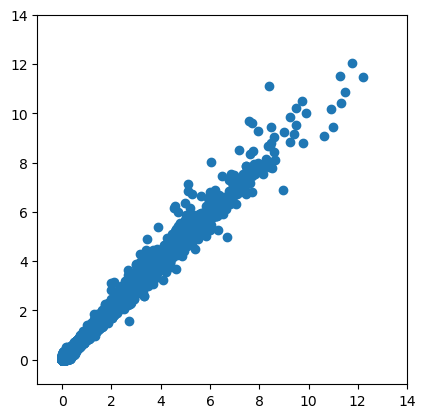

In [ ]:
plt.scatter(Xr.flatten(), smap_ml.data.flatten())
plt.gca().set_aspect('equal')
plt.xlim(-1, 14)
plt.ylim(-1, 14)
plt.show()